In [1]:
!pip install kaggle


In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/


In [3]:
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d 'pronaydebnath1/celeb-fbi'


Dataset URL: https://www.kaggle.com/datasets/pronaydebnath1/celeb-fbi
License(s): Community Data License Agreement - Permissive - Version 1.0


In [5]:
# Unzip the downloaded file
!unzip celeb-fbi.zip -d /content/celeb_fbi


Streaming output truncated to the last 5000 lines.
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3254_6.2h_82w_male_65a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3256_5.7h_54w_female_36a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3257_5.9h_70w_male_76a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3259_5.8h_54w_female_48a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/325_6.5h_111w_male_34a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3260_5.6h_47w_female_43a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3261_5.7h_51w_female_48a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3262_6.7h_100w_male_35a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3263_6.1h_78w_male_56a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3264_5.6h_56w_female_42a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3265_5.7h_63w_female_42a.png  
  inflating: /content/celeb_fbi/Celeb-FBI Dataset/3266_5.8h_65w_mal

In [3]:
import cv2
import mediapipe as mp
import os
import pandas as pd
import math
import re

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# Function to extract facial landmarks
def get_facial_landmarks(image):
    # Convert the image to RGB (MediaPipe uses RGB, not BGR)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    if not results.multi_face_landmarks:
        return None  # No landmarks found

    landmarks = results.multi_face_landmarks[0]

    # Extract landmarks for the forehead, chin, left ear, and right ear
    # Forehead: landmark[10] (point above the eyes)
    # Chin: landmark[152] (on the chin)
    # Left ear: landmark[234] (ear lobe)
    # Right ear: landmark[454] (ear lobe)

    forehead = landmarks.landmark[10]
    chin = landmarks.landmark[152]
    left_ear = landmarks.landmark[234]
    right_ear = landmarks.landmark[454]

    # Convert the relative landmark positions to pixel coordinates (assuming the image is of type BGR)
    height, width, _ = image.shape
    forehead_coords = (int(forehead.x * width), int(forehead.y * height))
    chin_coords = (int(chin.x * width), int(chin.y * height))
    left_ear_coords = (int(left_ear.x * width), int(left_ear.y * height))
    right_ear_coords = (int(right_ear.x * width), int(right_ear.y * height))

    # Return the coordinates
    return forehead_coords, chin_coords, left_ear_coords, right_ear_coords

# Function to calculate Euclidean distance between two points (x1, y1) and (x2, y2)
def distance_calculator(x1, y1, x2, y2):
    return math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

# Function to parse height, weight, and gender from the filename
def extract_info_from_filename(filename):
  name_arr = filename.split("_")
  serial_no = name_arr[0]
  height = name_arr[1].split("h")[0]
  weight = name_arr[2].split("w")[0]
  if (name_arr[3] == 'male'or name_arr[3] == 'Male'):
    gender = 1
  elif (name_arr[3] == 'female'or name_arr[3] == 'Femlale' or name_arr[3] == "Female"):
    gender = 0
  else :
    gender = "nan"
  age = name_arr[-1].split("a")[0]
  return height, weight, gender, age

# Initialize empty list to store the data
data = []

# Define the folder where the images are located
image_folder = '/content/celeb_fbi/Celeb'  # Update this with your folder path

# Process all images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(('.jpg', '.png')):  # Process only image files
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)

        # Get facial landmarks and distances
        landmarks = get_facial_landmarks(image)
        if landmarks:
            forehead_coords, chin_coords, left_ear_coords, right_ear_coords = landmarks

            # Calculate distances using distance_calculator function
            forehead_chin_distance = distance_calculator(forehead_coords[0], forehead_coords[1], chin_coords[0], chin_coords[1])
            left_ear_right_ear_distance = distance_calculator(left_ear_coords[0], left_ear_coords[1], right_ear_coords[0], right_ear_coords[1])

            # Extract height, weight, and gender from the filename
            height, weight, gender, age = extract_info_from_filename(filename)

            # If any of the extracted details are None, skip this entry
            if height is None or weight is None or gender is None:
                continue

            # Append data to the list
            data.append({
                "gender": gender,
                "forehead_chin": forehead_chin_distance,
                "left_ear_right_ear": left_ear_right_ear_distance,
                "height": height,
                "weight": weight,
                "age": age
            })

# Convert the list to a pandas DataFrame
dataset = pd.DataFrame(data, columns=["gender", "forehead_chin", "left_ear_right_ear", "height", "weight", "age"])

# Save the dataset to a CSV file
dataset.to_csv('dataset.csv', index=False)

print("Dataset saved to 'dataset.csv'")


Dataset saved to 'dataset.csv'


In [1]:
!pip install mediapipe
!pip install --upgrade mediapipe opencv-python pandas
!pip install --upgrade pip setuptools wheel


In [54]:
import pandas as pd
df = pd.read_csv("/content/dataset.csv")

In [55]:
df.sample(5)

,gender,forehead_chin,left_ear_right_ear,height,weight,age
3381,0.0,67.119297,38.118237,5.10,58.0,33
4172,0.0,71.112587,60.074953,5.5,56.0,40
1769,0.0,35.057096,31.016125,5.2,0.0,39
1068,1.0,81.908486,57.775427,5.6,112.0,48
2026,0.0,39.115214,29.154759,5.9,0.0,43


model start here

In [56]:
df[df.height == 0.0]

,gender,forehead_chin,left_ear_right_ear,height,weight,age


In [57]:
df.drop(df[df['weight'] == 0.0].index, inplace=True)


In [58]:
df.gender.unique()

array([ 1.,  0., nan])

In [59]:
df.dropna(inplace=True )

In [60]:
df.shape

(3563, 6)

In [61]:
df.isnull().sum()

,0
gender,0
forehead_chin,0
left_ear_right_ear,0
height,0
weight,0
age,0


In [62]:
df[df.duplicated()]

,gender,forehead_chin,left_ear_right_ear,height,weight,age


In [63]:
df['height'] = pd.to_numeric(df['height'], errors='coerce')  # Converts non-numeric values to NaN

# Step 2: (Optional) Drop rows with NaN values
df.dropna(subset=['height'], inplace=True)

# Step 3: Convert the column to float
df['height'] = df['height'].astype(float)

df['weight'] = pd.to_numeric(df['weight'], errors='coerce')  # Converts non-numeric values to NaN

# Step 2: (Optional) Drop rows with NaN values
df.dropna(subset=['weight'], inplace=True)

# Step 3: Convert the column to float
df['weight'] = df['weight'].astype(float)

df['age'] = pd.to_numeric(df['age'], errors='coerce')  # Converts non-numeric values to NaN

# Step 2: (Optional) Drop rows with NaN values
df.dropna(subset=['age'], inplace=True)

# Step 3: Convert the column to float
df['age'] = df['age'].astype(float)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3558 entries, 0 to 4172
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              3558 non-null   float64
 1   forehead_chin       3558 non-null   float64
 2   left_ear_right_ear  3558 non-null   float64
 3   height              3558 non-null   float64
 4   weight              3558 non-null   float64
 5   age                 3558 non-null   float64
dtypes: float64(6)
memory usage: 194.6 KB


In [65]:
df.shape

(3558, 6)

In [66]:
height_df = df.drop(columns = "weight")


In [67]:
height_df.columns

Index(['gender', 'forehead_chin', 'left_ear_right_ear', 'height', 'age'], dtype='object')

In [68]:
df[df.gender.isnull()]

,gender,forehead_chin,left_ear_right_ear,height,weight,age


In [69]:
X = df[['gender', 'forehead_chin', 'left_ear_right_ear', 'age']].values
y = df['height'].values

In [70]:
len(X)

3558

In [71]:
df[df.gender == 1]

,gender,forehead_chin,left_ear_right_ear,height,weight,age
0,1.0,93.048375,63.126856,6.10,76.0,42.0
4,1.0,39.012818,30.016662,5.10,94.0,39.0
5,1.0,124.149104,121.334249,6.30,81.0,106.0
6,1.0,65.030762,60.033324,5.80,78.0,71.0
7,1.0,41.436699,31.000000,6.20,87.0,59.0
...,...,...,...,...,...,...
4150,1.0,39.623226,26.925824,6.20,84.0,41.0
4157,1.0,123.000000,65.276336,6.00,74.0,41.0
4164,1.0,65.007692,67.000000,5.10,84.0,62.0
4165,1.0,39.000000,30.016662,5.11,88.0,54.0


2846
2846
Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 26.7617 - val_loss: 5.6933
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8653 - val_loss: 1.4952
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2288 - val_loss: 0.8625
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7543 - val_loss: 0.6541
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6416 - val_loss: 0.5727
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5698 - val_loss: 0.5321
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5442 - val_loss: 0.5069
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5166 - val_loss: 0.4879
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4864 - val_loss: 0.4717
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4666 - val_loss: 0.4477
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4511 - val_loss: 0.4372
Epoch 12/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4436 - val_

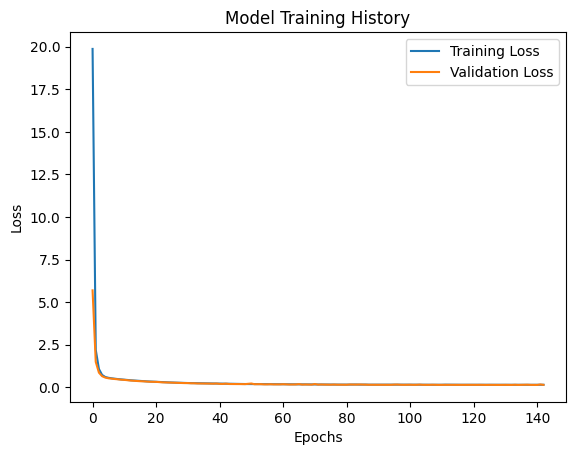

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


# X = dataset[['gender', 'forehead_chin', 'left_ear_right_ear', 'age']].values
# y = dataset['height'].values

# X[:, 0] = np.where(X[:, 0] == 'M', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_train to a DataFrame for easier processing
X_train_df = pd.DataFrame(X_train)

# Step 1: Replace problematic entries with NaN
X_train_df = X_train_df.replace(['', '.png', 'nan'], np.nan)

# Step 2: Handle missing values (either fill or drop)
X_train_df = X_train_df.fillna(0)  # Example: Fill NaN with 0
# Or drop rows with NaN: X_train_df.dropna(inplace=True)

# Step 3: Convert columns to numeric
X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')

# Step 4: Convert back to NumPy array
X_train_cleaned = X_train_df.values

# Print the cleaned dataset
# print(X_train_cleaned)

X_train = X_train_cleaned
y_train_cleaned = []
for value in y_train:
    if isinstance(value, str) and ' ' in value:
        y_train_cleaned.append(float(value.split(' ')[0]))  # Take only the first number
    else:
        y_train_cleaned.append(float(value))  # Convert directly to float
y_train = np.array(y_train_cleaned)  # Convert back to NumPy array

# Ensure y_train contains no NaNs or invalid values
y_train = pd.Series(y_train).fillna(y_train.mean()).values  # Replace NaNs with mean


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(len(X_train))
print(len(y_train))


model = Sequential()

model.add(Dense(units=64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train, epochs=500,validation_split=0.2, callbacks=[early_stopping])

# Step 1: Inspect and Clean X_train
X_test_df = pd.DataFrame(X_test)
X_test_df = X_test_df.replace(['', '.png', 'nan'], np.nan)  # Replace invalid entries with NaN
X_test_df = X_test_df.fillna(0)  # Fill NaNs with 0
X_test_df = X_test_df.apply(pd.to_numeric, errors='coerce')  # Ensure all columns are numeric
X_test = X_test_df.values  # Convert back to NumPy array

# Step 2: Clean y_train
# Handle concatenated strings like '6.1 0' in y_train
y_test_cleaned = []
for value in y_test:
    if isinstance(value, str) and ' ' in value:
        y_test_cleaned.append(float(value.split(' ')[0]))  # Take only the first number
    else:
        y_test_cleaned.append(float(value))  # Convert directly to float
y_test = np.array(y_test_cleaned)  # Convert back to NumPy array

# Ensure y_train contains no NaNs or invalid values
y_test = pd.Series(y_test).fillna(y_test.mean()).values  # Replace NaNs with mean


test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")

y_pred = model.predict(X_test)

for i in range(5):
    print(f"Predicted: {y_pred[i][0]:.2f}, Actual: {y_test[i]}")

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
model.save("h.h5", save_format="h5")


In [73]:
def predict(input_data):
    input_data_df = pd.DataFrame([input_data], columns=["gender", "forehead_chin", "left_ear_right_ear", "age"])
    input_data_df = input_data_df.replace(['', '.png', 'nan'], np.nan)
    input_data_df = input_data_df.fillna(0)
    input_data_df = input_data_df.apply(pd.to_numeric, errors='coerce')
    input_data_scaled = scaler.transform(input_data_df.values)
    predicted_height = model.predict(input_data_scaled)
    return predicted_height[0][0]

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

def get_facial_landmarks(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0]
    forehead = landmarks.landmark[10]
    chin = landmarks.landmark[152]
    left_ear = landmarks.landmark[234]
    right_ear = landmarks.landmark[454]
    height, width, _ = image.shape
    forehead_coords = (int(forehead.x * width), int(forehead.y * height))
    chin_coords = (int(chin.x * width), int(chin.y * height))
    left_ear_coords = (int(left_ear.x * width), int(left_ear.y * height))
    right_ear_coords = (int(right_ear.x * width), int(right_ear.y * height))

    return forehead_coords, chin_coords, left_ear_coords, right_ear_coords
def distance_calculator(x1, y1, x2, y2):
    return math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

def extract_info_from_filename(filename):
  name_arr = filename.split("_")
  serial_no = name_arr[0]
  height = name_arr[1].split("h")[0]
  weight = name_arr[2].split("w")[0]
  if (name_arr[3] == 'male'or name_arr[3] == 'Male'):
    gender = 1
  elif (name_arr[3] == 'female'or name_arr[3] == 'Femlale' or name_arr[3] == "Female"):
    gender = 0
  else :
    gender = "nan"
  age = name_arr[-1].split("a")[0]
  return height, weight, gender, age

forehead_chin_distance = 0
left_ear_right_ear_distance = 0
# Define the folder where the images are located
filename = '/content/vk.jpeg'  # Update this with your folder path

# Process all images in the folder

if filename.endswith(('.jpg', '.jpeg','.png')):  # Process only image files
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path)

        # Get facial landmarks and distances
    landmarks = get_facial_landmarks(image)
    if landmarks:
        forehead_coords, chin_coords, left_ear_coords, right_ear_coords = landmarks


        forehead_chin_distance = distance_calculator(forehead_coords[0], forehead_coords[1], chin_coords[0], chin_coords[1])
        left_ear_right_ear_distance = distance_calculator(left_ear_coords[0], left_ear_coords[1], right_ear_coords[0], right_ear_coords[1])







        left_ear_right_ear_distance = distance_calculator(left_ear_coords[0], left_ear_coords[1], right_ear_coords[0], right_ear_coords[1])
new_data = [1, forehead_chin_distance, left_ear_right_ear_distance, 36]
predicted_height = predict(new_data)
print(f"Predicted Height: {predicted_height:.2f} ")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted Height: 5.79 


In [74]:
X = df[['gender', 'forehead_chin', 'left_ear_right_ear', 'height','age']].values
y = df['weight'].values

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4246.7153 - val_loss: 2604.0244
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1552.3898 - val_loss: 368.2004
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 316.8515 - val_loss: 227.7833
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 215.0013 - val_loss: 164.2692
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 146.0554 - val_loss: 132.6816
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 126.2832 - val_loss: 115.0788
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104.5568 - val_loss: 102.6293
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95.6266 - val_loss: 96.1858
Epoch 9/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.7561 - val_loss: 91.7689
Epoch 10/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.1570 - val_loss: 90.7319
Epoch 11/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.1008 - val_loss: 87.4720
Epoch 12/200
72/72 ━━━━━━━━━━━━━━━━

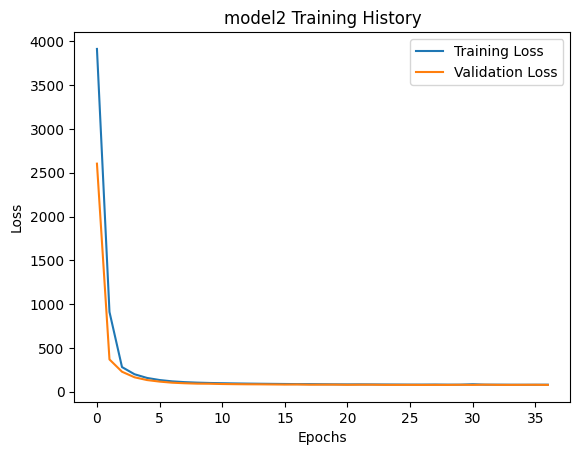

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values and invalid entries in X_train
X_train_df = pd.DataFrame(X_train)
X_train_df = X_train_df.replace(['', '.png', 'nan'], np.nan)  # Replace invalid values
X_train_df = X_train_df.dropna()  # Drop rows with NaN (or consider filling with column mean)
X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')  # Ensure all numeric
X_train = X_train_df.values  # Convert back to NumPy

# Clean y_train
y_train_cleaned = []
for value in y_train:
    if isinstance(value, str) and ' ' in value:
        y_train_cleaned.append(float(value.split(' ')[0]))  # Take only the first number
    else:
        y_train_cleaned.append(float(value))
y_train = np.array(y_train_cleaned)
y_train = pd.Series(y_train).fillna(y_train.mean()).values  # Replace NaNs with mean if needed

# Scaling the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural network model2
model2 = Sequential()
model2.add(Dense(units=64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=1))

# Compile the model2 with a small learning rate for stable convergence
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model2
history = model2.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])

# Test Data Preprocessing
X_test_df = pd.DataFrame(X_test)
X_test_df = X_test_df.replace(['', '.png', 'nan'], np.nan)  # Replace invalid values
X_test_df = X_test_df.fillna(0)  # Fill NaNs (or consider filling with column mean)
X_test_df = X_test_df.apply(pd.to_numeric, errors='coerce')
X_test = X_test_df.values

y_test_cleaned = []
for value in y_test:
    if isinstance(value, str) and ' ' in value:
        y_test_cleaned.append(float(value.split(' ')[0]))
    else:
        y_test_cleaned.append(float(value))
y_test = np.array(y_test_cleaned)
y_test = pd.Series(y_test).fillna(y_test.mean()).values

# Evaluate the model2
test_loss = model2.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")

# Make predictions on test data
y_pred = model2.predict(X_test)

# Display predictions and actual values for first 5 samples
for i in range(5):
    print(f"Predicted: {y_pred[i][0]:.2f}, Actual: {y_test[i]}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model2 Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [48]:
model2.save("w.h5")

In [76]:
def predict(input_data):

    input_data_df = pd.DataFrame([input_data], columns=["gender", "forehead_chin", "left_ear_right_ear", "height", "age"])

    input_data_df = input_data_df.replace(['', '.png', 'nan'], np.nan)
    input_data_df = input_data_df.fillna(0)
    input_data_df = input_data_df.apply(pd.to_numeric, errors='coerce')
    input_data_scaled = scaler.transform(input_data_df.values)
    predicted_weight = model2.predict(input_data_scaled)

    return predicted_weight[0][0]



mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

def get_facial_landmarks(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0]
    forehead = landmarks.landmark[10]
    chin = landmarks.landmark[152]
    left_ear = landmarks.landmark[234]
    right_ear = landmarks.landmark[454]
    height, width, _ = image.shape
    forehead_coords = (int(forehead.x * width), int(forehead.y * height))
    chin_coords = (int(chin.x * width), int(chin.y * height))
    left_ear_coords = (int(left_ear.x * width), int(left_ear.y * height))
    right_ear_coords = (int(right_ear.x * width), int(right_ear.y * height))

    return forehead_coords, chin_coords, left_ear_coords, right_ear_coords
def distance_calculator(x1, y1, x2, y2):
    return math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

def extract_info_from_filename(filename):
  name_arr = filename.split("_")
  serial_no = name_arr[0]
  height = name_arr[1].split("h")[0]
  weight = name_arr[2].split("w")[0]
  if (name_arr[3] == 'male'or name_arr[3] == 'Male'):
    gender = 1
  elif (name_arr[3] == 'female'or name_arr[3] == 'Femlale' or name_arr[3] == "Female"):
    gender = 0
  else :
    gender = "nan"
  age = name_arr[-1].split("a")[0]
  return height, weight, gender, age

forehead_chin_distance = 0
left_ear_right_ear_distance = 0
# Define the folder where the images are located
filename = '/content/yash.png'  # Update this with your folder path

# Process all images in the folder

if filename.endswith(('.jpg', '.jpeg','.png')):  # Process only image files
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path)

        # Get facial landmarks and distances
    landmarks = get_facial_landmarks(image)
    if landmarks:
        forehead_coords, chin_coords, left_ear_coords, right_ear_coords = landmarks


        forehead_chin_distance = distance_calculator(forehead_coords[0], forehead_coords[1], chin_coords[0], chin_coords[1])
        left_ear_right_ear_distance = distance_calculator(left_ear_coords[0], left_ear_coords[1], right_ear_coords[0], right_ear_coords[1])




new_data = [1,forehead_chin_distance, left_ear_right_ear_distance,5.79, 36]
predicted_weight = predict(new_data)
print(f"Predicted Weight: {predicted_weight:.2f} kg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted Weight: 70.46 kg
